# Dataset and Database Setup

This dataset contains all user posts between early 2008 and July 2016 in the two subreddits: **r/MensRights** (https://www.reddit.com/r/MensRights/) and **r/Feminism** (https://www.reddit.com/r/Feminism/). The data was pulled from reddit using its web API.

Each reddit post is stored as a MongoDB document in the collection corresponding to the subreddit:
```python
db = client["reddit_polarization"]
men_collection = db["MensRights"]
fem_collection = db["Feminism"]
```
Each document has the following fields: 

* created_utc
* date
* ups
* subreddit_id
* link_id
* name
* score_hidden
* author_flair_css_class
* author_flair_text
* subreddit
* id
* removal_reason
* gilded
* downs
* archived
* author
* score
* retrieved_on
* body
* distinguished
* edited
* controversiality
* parent_id

First we need to connect to the mongodb. We can list the collections that correspond to different subreddits:

In [1]:
from pymongo import MongoClient
import pprint

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
db.collection_names()[-2:]

[u'Feminism', u'MensRights']

Here is one post from **r/MensRights**:

In [2]:
posts = db["MensRights"].find()
pprint.pprint(next(posts))

{u'_id': ObjectId('57c5ddd779a3030ce06585e6'),
 u'archived': True,
 u'author': u'sibqm_lmvm',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u"That event actually happened when I was in sixth grade, way back in the day :)\n\nIm actually studying to be a teacher right now though, and I'd like to be as egalitarian as possible. But I might switch my major to something involving abnormal psych, where I'll have to be extremely non-judging.",
 u'controversiality': 0,
 u'created_utc': datetime.datetime(2012, 4, 30, 20, 0, 15),
 u'date': datetime.datetime(2012, 4, 30, 0, 0),
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c4iiwis',
 u'link_id': u't3_t03pt',
 u'name': u't1_c4iiwis',
 u'parent_id': u't1_c4iiupq',
 u'removal_reason': nan,
 u'retrieved_on': 1428829641,
 u'score': 2,
 u'score_hidden': False,
 u'subreddit': u'MensRights',
 u'subreddit_id': u't5_2qhk3',
 u'tokens_njv': u'event happen sixth grade way day study teacher right 

Among all the fields, the following are the ones that contain relevant information for this project (i.e. to study the interaction between authors in **r/MensRights** and **r/Feminism**)

* **created_utc**: datetime; converted from the timestamp of a post.
* **date**: datetime; map each **created_utc** to the one with `hour`, `minute`, `second` set to 0. This is useful for grouping data.  
* **author**: unicode; user ID of an author.
* **subreddit**: unicode; name of subreddit ("MensRights" or "Feminism").
* **body**: unicode; a unicode string containing the raw text of the post. May contain tags that need to be properly processed.

--------------------

The reason I chose **r/MensRights** and **r/Feminism** is that they represent typical idealogically opposing social groups, and the posts in these two subreddits may contain evidence of trolling (i.e. people post inflammatory or inappropriate messages or comments online for the purpose of upsetting other users and provoking a response.)

To better characterize the trolling behavior of different authors, the set of authors is divided into three groups:

* *MensRight-only*: those who post only in **r/MensRights**
* *Feminism-only*: those who post only in **r/Feminism**
* *Cross-poster* (or boundary crosser): those who post in both subreddits

Keep in mind that the way the set of authors is divided as such *does not make sense unless* we impose a **time interval** $I = [t_{0}, t_{1}]$: a user $u^{c}$ is a *Cross-poster* in $[t_{0}, t_{1}]$ as long as some **r/MensRights** post $p_{m}$ and some **r/Feminism** post $p_{f}$ were posted by the same user $u^{c}$ between timestamp $t_{0}$ and $t_{1}$; on the other hand, a user $u^{m}$ is a *MensRights-only* if all the posts by $u^{m}$ within the interval $I = [t_{0}, t_{1}]$ are exclusively from **r/MensRights**; likewise for *Feminism-only*.

I'll show concrete example explaining what I mean by the three groups of users. As you'll see, we'll perform ETL on pandas dataframes to identify these groups of users. 

------------------

### Some rationale for studying cross-poster

**r/MensRights** and **r/Feminism** are a typical example of online social communities with a conflicting relationship. You can imagine they are "separated" by a boundary that most people are not likely to cross (e.g. post in both subreddits on a regular basis). However, some aggresive users may occasionaly start discussion on some controversial issues in the subreddit she/he is against, which may provoke users in the opposing subreddit to "counterattack". This may lead to elevated antagonization that may be manifested as increased **cross-posting** activity at some point in time.

Here is a concrete example of how we can identify **cross-poster**, **MensRight-only** and **Feminism-only** within the first ten days in June 2014 (that is, $t_{0} =$ `datetime(2014, 1, 1)`, and $t_{1} =$ `datetime(2014, 6, 11)`) 

In [3]:
import datetime
import pandas as pd

# Pull data from mongodb within [6/1/2014, 6/11/2014]  from both subreddits
low = datetime.datetime(year=2014, month=6, day=1)
high = datetime.datetime(year=2014, month=6, day=11)
query = db["MensRights"].find({"created_utc": {"$lte": high, "$gte": low}}, 
                              {"author": 1, "created_utc": 1, "subreddit": 1, "body": 1})
men = pd.DataFrame(list(query))

query = db["Feminism"].find({"created_utc": {"$lte": high, "$gte": low}},
                            {"author": 1, "created_utc": 1, "subreddit": 1, "body": 1})
fem = pd.DataFrame(list(query))

june2014 = pd.concat([men, fem], axis=0)
june2014[:10]

,_id,author,body,created_utc,subreddit
0,57c1306679a3030a58e3363e,termd,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,MensRights
1,57c1306679a3030a58e34252,Piroko,"[""It's a ferony.""](http://www.cc.com/video-cli...",2014-06-01 00:03:39,MensRights
2,57c1306679a3030a58e3442b,not_just_amwac,Eating disorders aren't restricted to just sta...,2014-06-01 00:04:07,MensRights
3,57c1306679a3030a58e345f9,termd,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,MensRights
4,57c1306779a3030a58e34a8f,Dann01,How many subscribers of 2x do you think are fa...,2014-06-01 00:05:55,MensRights
5,57c1306779a3030a58e34abc,Meistermalkav,"""I had no idea as well, I just assumed it was ...",2014-06-01 00:05:57,MensRights
6,57c1306779a3030a58e35054,elebrin,"It's funny, but when I think of an ideal commu...",2014-06-01 00:07:33,MensRights
7,57c1306779a3030a58e35972,phySi0,But that's the point. Men's value is earned. T...,2014-06-01 00:10:05,MensRights
8,57c1306779a3030a58e35f10,iNQpsMMlzAR9,&gt; You ignored all my actual points\n\nBecau...,2014-06-01 00:11:39,MensRights
9,57c1306779a3030a58e36035,bohalls,I think the point was the MRA chiming into qui...,2014-06-01 00:11:59,MensRights


Given `june2014`, we group the rows by the `author`, and aggregate by counting the number of unique values in `subreddit` of the individual rows, which leads to `author_info`:

In [4]:
author_info = june2014.groupby("author").apply(lambda df: len(df["subreddit"].unique()))
author_info.name = "subreddits"
author_info = author_info.reset_index(drop=False)
pd.concat([author_info[author_info["subreddits"] == 2][:2],
           author_info[author_info["subreddits"] == 1][:2]], axis=0)

,author,subreddits
56,AdumbroDeus,2
123,Astiolo,2
0,-Fender-,1
1,-JWF,1


Cross-posters (e.g. `AdumbroDeus`, `Astiolo`) are those with the aggregated value of 2, while MensRights-only or Feminism-only (e.g. `-Fender-`, `-JWF`) are those with value of 1.

Note that `june2014` contains only information about each post, while `author_info` is derived from `june2014` that contains meta information about each author. We can do a SQL join on their common column `author` to obtain a more complete picture:

In [5]:
june2014 = june2014.merge(author_info, left_on="author", right_on="author")
june2014 = june2014[["body", "created_utc", "subreddit", "author", "subreddits"]]
june2014[-5:]

,body,created_utc,subreddit,author,subreddits
17925,It's truly sensationalist dreck disguised as a...,2014-06-10 21:03:54,Feminism,enfp_ocd,1
17926,I don't know what to say. This infuriates me t...,2014-06-10 21:08:12,Feminism,Gingerosaurus,1
17927,"I don't think I did it right, here's a link to...",2014-06-10 22:02:21,Feminism,AnthroPoBoy,1
17928,"Gosh, we need a little lesson about equalism. ...",2014-06-10 22:22:05,Feminism,Dirtydan6669,1
17929,This incident did not occur in a vacuum. All o...,2014-06-10 22:23:56,Feminism,mch3rry,1


Given the dataframe `june2014` that contains information about both post and author, we can easily identify the three groups of authors and their posts:

In [6]:
# crossposter:
june2014[june2014["subreddits"] == 2]["author"].unique()[:5]

array([u'autowikibot', u'phatphace', u'Astiolo', u'deit9000',
       u'Yo_Soy_Candide'], dtype=object)

In [7]:
# crossposter `Astiolo`'s post
june2014[june2014["author"] == "Astiolo"]

,body,created_utc,subreddit,author,subreddits
2404,I don't really see her view as particularly co...,2014-06-01 05:16:30,MensRights,Astiolo,2
2405,"I think the biologist was spot on with this, s...",2014-06-06 15:52:29,Feminism,Astiolo,2


In [8]:
# MensRights-only:
june2014[(june2014["subreddits"] == 1) & (june2014["subreddit"] == "MensRights")]["author"].unique()[:5]

array([u'termd', u'Piroko', u'not_just_amwac', u'Dann01', u'Meistermalkav'], dtype=object)

In [9]:
# MensRights-only `termd`'s post
june2014[june2014["author"] == "termd"]

,body,created_utc,subreddit,author,subreddits
0,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,MensRights,termd,1
1,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,MensRights,termd,1


In [10]:
# Feminism-only
june2014[(june2014["subreddits"] == 1) & (june2014["subreddit"] == "Feminism")]["author"].unique()[:5]

array([u'arwenface', u'FoKFill', u'a_grotesqueanimal', u'sinn7',
       u'IndieLady'], dtype=object)

In [11]:
# Feminism-only `arwenface`'s post
june2014[june2014["author"] == "arwenface"]

,body,created_utc,subreddit,author,subreddits
16826,"The pink dump truck is a nice touch, though.",2014-06-01 01:06:18,Feminism,arwenface,1


# Temporal Analysis of Cross-posting

Now that we have some intuitive understanding of the data, the next question we want to address is figuring out how cross-posting activity changes over time. Specifically, we want to compute **the numbers of authors in the three groups** ($N_{men\_only}(I), N_{fem\_only}(I), N_{crosspost}(I)$) as a function of the moving interval $I$. Note that the size of $I$ could range from one day to multiple days, depending on the granularity of our choice. Again, I'll show concrete examples of $N_{men\_only}(I), N_{fem\_only}(I), N_{crosspost}(I)$.

We need a helper function `authorlist_by_date` for data transformation:
1. Pull the data from MongoDB and store the data in dataframe
2. Group the rows in the dataframe by individual date (column `date`), and aggregate the rows in each group by merging the lists of authors.

Applying the function on the two collections, we end up with two dataframes `mensrights`, `feminism` and two series `men_author_groupby_day`, `fem_author_groupby_day`

In [12]:
def authorlist_by_date(subreddit):
    df = pd.DataFrame(list(db[subreddit].find({},
                                              {"author": 1, "created_utc": 1, "date": 1, "subreddit": 1, "body": 1})))
    
    author_groupby_day = df.groupby("date").apply(lambda x: x["author"].unique())
    return df, author_groupby_day

mensrights, men_author_groupby_day = authorlist_by_date("MensRights")
feminism, fem_author_groupby_day = authorlist_by_date("Feminism")

The two series are indexed by date, and each entry contains the list of authors who posted on the given date

In [13]:
men_author_groupby_day[:2]

date
2008-03-21      [kanuk876]
2008-03-24    [WorcesterM]
dtype: object

In [14]:
fem_author_groupby_day[:2]

date
2009-02-06    [stellar1]
2009-04-13      [Smight]
dtype: object

So `[kanuk876]` are all the authors who posted in **r/MensRights** on 3/21/2008, and `[stellar1]` are all the authors who posted in **r/Feminism** on 2/6/2009.

Now concatenate them along axis=1. Note the indices (`created_utc`) are automatically aligned.

In [15]:
author_groupby_day = pd.concat([men_author_groupby_day, fem_author_groupby_day],
                               axis=1, keys=["men_author", "fem_author"])
author_groupby_day = author_groupby_day.sort_index(axis=0)
author_groupby_day[-5:]

,men_author,fem_author
date,,
2016-07-27,"[Liv47, R_BirthStrike, WolfyCat, baserace, rww...","[WorstGringoNA, grantrob, i_have_a_semicolon, ..."
2016-07-28,"[juboboy, subzero_600, escobari, cld8, LenTheL...","[Soggy_Biscuit_, saccharind, DJWalnut, Hobbes_..."
2016-07-29,"[qemist, equiposeur, SigmundFloyd76, i_have_a_...","[HeavenlySun, ricnus, Hobbes_the_tiger, notano..."
2016-07-30,"[Real_nimr0d, elebrin, sillymod, JohnKimble111...","[Amvega, demmian, conuly, Hobbes_the_tiger, Ad..."
2016-07-31,"[Lethn, hhamama66, civilsaint, Foregen_Is_Life...","[polot38, HeavenlySun, weinbrandbabsi, raloicl..."


For each row of `author_groupby_day`, we have two lists of authors $L_{men}$ (e.g. `[Liv47, R_BirthStrike, WolfyCat, ...`) and $L_{fem}$ (e.g. `[WorstGringoNA, grantrob, ...`), the counts of **crossposters**, **MensRights-only** and **Feminism-only** can be obtained as follows:

* $N_{crosspost} = |L_{men} \cap L_{fem}|$ (intersection)
* $N_{men\_only} = |L_{men} - L_{fem}|$ (set difference)
* $N_{fem\_only} = |L_{fem} - L_{fem}|$ (set difference)

Note that in the notation above, we've omitted the time interval $I$, which spans only one day.

To reduce the variation of the counts, we need to change the level of granularity by increasing the size of $I$ from one day to 10 days (+/- 5 days centered on each date). For example, 

`2016-07-27` will be changed to `[2016-07-22, 2016-07-31]`

We define a helper function `compute_ratio_author` to be applied on each row of dataframe `author_groupby_day`. It does the following:
* For each `date` (`name` field of each `row`), find all the dates (`days`) within the interval
* Merge the author lists from columns (`men_author` and `fem_author`) that fall within the interval, so the new lists of authors span the entire interval rather than only one day.
* Compute the counts of the each groups of authors using the above equations, and optionally normalize by their sum. 

In [16]:
radius = 5

def compute_ratio_author(row, normalize=True):
    """
    row: Series
    row.name: index value of the row (i.e. datetime)
    
    For each row (corresponding to a calendar date), compute the percentage of 
    the three groups of authors (with or without normalization)
    """
    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    men_author = []
    fem_author = []
    for d in days:
        if d in author_groupby_day.index:
            if author_groupby_day.ix[d, "men_author"] is not np.nan:
                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))
    crossposter = set(men_author) & set(fem_author)
    men_only_author = set(men_author) - crossposter
    fem_only_author = set(fem_author) - crossposter
    ratio = np.array([len(men_only_author), len(fem_only_author), len(crossposter)], dtype=np.float)

    if normalize:
        ratio = ratio / ratio.sum()
    return pd.Series(ratio)


Apply `compute_ratio_author` on each row of `author_groupby_day`:

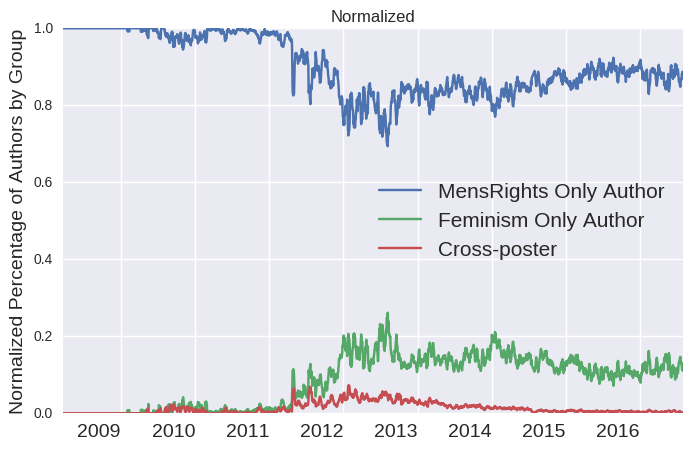

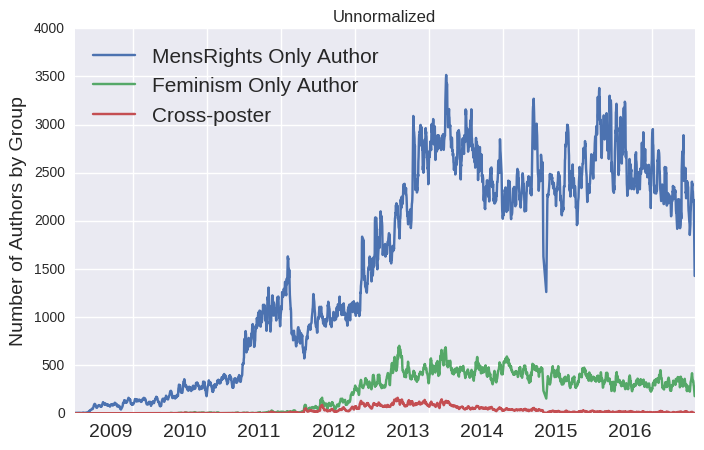

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# `normalized = False` corresponds to the raw counts
# `normalized = True` corresponds to ratios (divide raw counts by sum, so that sum of ratios equals one)
for normalize in (True, False):
    ratio = author_groupby_day.apply(lambda row: compute_ratio_author(row, normalize=normalize), axis=1)
    ratio.columns = ["MensRights Only Author", "Feminism Only Author", "Cross-poster"]
    ax = ratio.plot()
    ax.set_xticklabels(map(str, range(2009, 2017)), size=14, rotation="horizontal")
    sns.set_style("darkgrid")
    plt.legend(loc=0, prop={"size": 15})
    plt.xlabel("")

    if normalize:
        plt.ylabel("Normalized Percentage of Authors by Group", fontsize=14)
        plt.title("Normalized")
    else:
        plt.ylabel("Number of Authors by Group", fontsize=14)
        plt.title("Unnormalized")
    plt.show()

Let's take a look at the result of applying `compute_ratio_author` on `author_groupby_day`:

In [18]:
ratio[-10:]

,MensRights Only Author,Feminism Only Author,Cross-poster
date,,,
2016-07-22,2307.0,345.0,4.0
2016-07-23,2243.0,333.0,5.0
2016-07-24,2202.0,334.0,4.0
2016-07-25,2211.0,319.0,4.0
2016-07-26,2217.0,291.0,5.0
2016-07-27,2148.0,283.0,5.0
2016-07-28,1980.0,251.0,4.0
2016-07-29,1835.0,234.0,3.0
2016-07-30,1656.0,208.0,3.0


Using the notation defined previously, we have:

* $N_{men\_only}(I) = 8630$
* $N_{fem\_only}(I) = 621$
* $N_{crosspost}(I) = 147$

where $I$ = `[2016-07-22, 2016-07-31]` (centered on `2016-07-26`)

-------------------

Note that the above function `compute_ratio_author` outputs the numbers/ratios of **authors** across the three groups. We can also compute the numbers/ratios of **posts** from the three groups of authors using the following helper function `compute_ratio_post`:

In [ ]:
radius = 5

def compute_ratio_post(row, normalize=True):
    """
    row: Series
    row.name: index value of the row (i.e. datetime)
    
    For each row (corresponding to a calendar date), compute the percentage of 
    the three groups of authors (with or without normalization)
    """
    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    men_author = []
    fem_author = []
    for d in days:
        if d in author_groupby_day.index:
            if author_groupby_day.ix[d, "men_author"] is not np.nan:
                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))
    crossposter = set(men_author) & set(fem_author)
    men_only_author = set(men_author) - crossposter
    fem_only_author = set(fem_author) - crossposter
    """
    Note taht up to now this function does the SAME as `compute_ratio_author`
    Next the function counts the number of posts from `men_only_author`, `fem_only_author`
    and `crossposter`
    """ 
    
    df_men = mensrights[(mensrights["date"] <= days[-1]) & (mensrights["date"] >= days[0])]
    df_fem = feminism[(feminism["date"] <= days[-1]) & (feminism["date"] >= days[0])]

    men_only_author_posts = (df_men["author"].isin(men_only_author)).sum()
    fem_only_author_posts = (df_fem["author"].isin(fem_only_author)).sum()

    crossposter_posts = (df_men["author"].isin(crossposter)).sum() + \
                        (df_fem["author"].isin(crossposter)).sum()


    ratio = np.array([men_only_author_posts, fem_only_author_posts, crossposter_posts], dtype=np.float)

    if normalize:
        ratio = ratio / ratio.sum()
    return pd.Series(ratio)

In [ ]:
# `normalized = False` corresponds to the raw counts
# `normalized = True` corresponds to ratios (divide raw counts by sum, so that sum of ratios equals one)
for normalize in (True, False):
    ratio = author_groupby_day.apply(lambda row: compute_ratio_post(row, normalize=normalize), axis=1)
    ratio.columns = ["From MensRights Only Author", "From Feminism Only Author", "From Cross-poster"]
    ax = ratio.plot()
    ax.set_xticklabels(map(str, range(2009, 2017)), size=14, rotation="horizontal")
    sns.set_style("darkgrid")
    plt.legend(loc=0, prop={"size": 15})
    plt.xlabel("")
    if normalize:
        plt.ylabel("Normalized Percentage of Posts by author Group", fontsize=14)
        plt.title("Normalized")
    else:
        plt.ylabel("Number of Posts by author group", fontsize=14)
        plt.title("Unnormalized")
    plt.show()

As we can see, **MensRights** users' activity overshadowed the **Feminism** users across all the four figures above.

Interestingly, the red curves (cross-posters) appear to be very peaky between mid 2012 to mid 2013. And although the count of cross-posters was the least among the three groups of users (the first two figures), the number of posts they generated seemed to be not proportional to their counts from late 2012 to early 2014 (the last two figure): the red curves were below green curves in the first two figures, but were above green curves in the last two figure, which means cross-posters generated even more posts than Feminism-only authors on average).

We probably have to perform some further analysis to figure out what triggered them to be unusually active during that period. For example, if the posts in the peaky region from cross-posters were focused on a narrow range of topics, they may have to be consistent in their usage of language. One way to test this hypothesis could be computing the divergence of linguisitc pattern $\delta(M_{t}, F_{t})$ (e.g. word frequencies) of posts from the two subreddits, and see if there is a valley for the divergence curve where we saw the peak in the red curves. 

In [ ]:
del men, men_author_groupby_day, fem, fem_author_groupby_day

### An aside about BOT

Quoting from Wikipedia: An Internet ***Bot***, also known as web robot, WWW robot or simply bot, is a software application that runs automated tasks (scripts) over the Internet. Typically, bots perform tasks that are both simple and structurally repetitive, at a much higher rate than would be possible for a human alone.

BOT in online social media can be annoying as they keep posting useless stuff. And the existence of posts from BOTs may introduce bias to our analysis.

We'll need to somehow have some idea about the extent of BOT in our data. One attribute that is distinctive about BOTs is they keep posting duplicated stuff. We can check if authors have this attribute very easily:

In [ ]:
# Check if an author's total number of posts is greater than the number of unique posts
def duplicate_post(df):
    return 1 if len(df["body"].unique()) < df.shape[0] else 0

In [ ]:
men_bot = mensrights.groupby("author").apply(duplicate_post)
fem_bot = feminism.groupby("author").apply(duplicate_post)

As we can see the authors who has posted duplicate posts account for only a small portion (i.e. `2595/115074` and `215/31772`)

In [ ]:
men_bot.shape[0], men_bot.sum(), fem_bot.shape[0], fem_bot.sum()

Take a sample of these authors:

In [ ]:
men_bot[men_bot == 1][:10]

Take a look at what they posted:

In [ ]:
mensrights[mensrights["author"] == "11thGRADEteacher"][["created_utc", "body"]]

It seems that our criteria for being a "bot" may be a little too liberal. The posts by `11thGRADEteacher` seem to be normal except that one or two or them were duplicate (maybe by mistake).

We may increase the standard for an author to be a "bot" as follows:

In [ ]:
# The user has posted more than 2 posts with exactly same content
def duplicate_post(df):
    return 1 if (len(df["body"].unique()) == 1) and (df.shape[0] > 2) else 0

In [ ]:
men_bot = mensrights.groupby("author").apply(duplicate_post)
fem_bot = feminism.groupby("author").apply(duplicate_post)

This time we end up with much fewer authors that meet this new criteria

In [ ]:
men_bot.shape[0], men_bot.sum(), fem_bot.shape[0], fem_bot.sum()

In [ ]:
men_bot[men_bot == 1][:10]

Again, take a look at what they posted:

In [ ]:
mensrights[mensrights["author"] == "Could_Care_Corrector"][["created_utc", "body"]]

In [ ]:
mensrights[mensrights["author"] == "200lbRockLobster"][["created_utc", "body"]]

As we can they, they post exactly same text repeatedly within a small time interval (or maybe periodically). Lukily these posts account for a tiny portion of our data, so for simplicity I won't bother to remove these posts in the analsis.

In [ ]:
print "Total posts: %d" % mensrights.shape[0]
print "Posts from potential BOTs: %d" % mensrights[mensrights["author"].isin(list(men_bot[men_bot==1].index))].shape[0]

In [ ]:
print "Total posts: %d" % feminism.shape[0]
print "Posts from potential BOTs: %d" % feminism[feminism["author"].isin(list(fem_bot[fem_bot==1].index))].shape[0]